# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### Table of Contents

[**Part 0: Get to Know the Data**](#Get-to-Know-the-Data)<br>
[1.1 Loading the data](#Loading)<br>
[1.1.1 Loading warnings](#Warnings)<br>
[1.1.2 Mixed Type columns an NaN Values](#Mixed-Type)<br>
[1.1.3 Sparsity](#Sparsity)<br>
[1.1.3.1 Columns](#Columns)<br>
[1.1.3.2 Rows](#Rows)<br>
[1.1.4 Cleaning Function](#Cleaning)<br>
[1.2.1 Transforming and One Hot Coding](#One-Hot)<br>
[1.3.1 Scaling](#Scaling)<br>

[**Part 1: Customer Segmentation Report**](#Segmentation_Report)<br>
[2.1.1 PCA Dimension Reduction](#PCA)<br>
[2.1.2 Interpret Principal Components](#Principal_Components)<br>
[2.2.1 Clustering](#Clustering)<br>
[2.2.2 Apply All Steps to the Customers Data](#Customers_Clustering)<br>
[2.2.3 Global vs Customers, comparing the Clusters](#Compare_Cluster)<br>

[**Part 2: Supervised Learning Model**](#Part2)<br>
[3.1.1 Investigating the data](#Investigating)<br>
[3.1.2 Finding the model](#Finding_Model)<br>
[3.2.1 Re-Do and Second Try](#try)<br>
[3.2.2 Learning Curves](#Learning_Curves)<br>
[3.3.1 Grid Search](#Grid)<br>

[**Part 3: Kaggle Competition**](#Part3)<br>
[4.1.1 Prepare the Test Data](#prepare_test)<br>
[4.1.2 Prediction and Results](#predict_kaggle)<br>


[**Appendix l: Conclusion and Future Work**](#apendixl)<br>

[**Appendix ll: Sources and Thanks**](#apendixll)





In [66]:
import sys
!{sys.executable} -m pip install progressbar

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline

## <a class="anchor" id="Get-to-Know-the-Data">Part 0: Get to Know the Data</a>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# <a class="anchor" id="Loading">1.1 Loading the data</a>

In [132]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
azdias.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [69]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


'Unnamed: 0' is the index from the file when it was saved, I will drop the old index and continue with the default index from pandas

In [70]:
# I should have saved it with index=False
azdias = azdias.drop('Unnamed: 0',1)
customers = customers.drop('Unnamed: 0',1)

# <a class="anchor" id="Warnings">1.1.1 Loading warnings</a>

It seams that some columns have some floats/ints mixed with string characters.

In [71]:
azdias.iloc[:,18].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [72]:
azdias.iloc[:,19].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

The mentioned columns 18 and 19 use X an d XX as nan chareacters. Are tthere oter object type columns with nan characters?

In [73]:
azdias[azdias.columns[azdias.dtypes == 'object'].values]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,4,22,D19_UNBEKANNT,1992-02-12 00:00:00,W
7,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
8,1A,1,13,NaN,1992-02-10 00:00:00,W
9,1E,1,15,D19_KOSMETIK,1992-02-10 00:00:00,W


In [74]:
azdias.CAMEO_DEUG_2015.unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [75]:
azdias.CAMEO_DEU_2015.unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [76]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [77]:
azdias.OST_WEST_KZ.unique()

array([nan, 'W', 'O'], dtype=object)

In [78]:
azdias.D19_LETZTER_KAUF_BRANCHE.unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
       'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
       'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object)

# <a class="anchor" id="Mixed-Type">1.1.2 Mixed Type columns an NaN Values</a>

Beside this notebook I created a dictionary with all nan values from the description in the excel file plus the known X and XX. I will now load the file and use it to convert the nan like values in the data set to np.nan() values.

In [79]:
nan_df = pd.read_csv('nan_list_altered.tsv', sep='\t')
nan_df.head()

,column,nan_values
0,AGER_TYP,['-1']
1,ALTERSKATEGORIE_GROB,"['-1','0']"
2,ANREDE_KZ,"['-1','0']"
3,BALLRAUM,['-1']
4,CAMEO_DEUG_2015,"['-1','X']"


Bevore I can use the file I have to convert the list like strings into python lists

In [80]:
#the lists became strings lexing and parsing
nan_df['nan_values'] = nan_df['nan_values'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))
nan_df.head()

,column,nan_values
0,AGER_TYP,[-1]
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ANREDE_KZ,"[-1, 0]"
3,BALLRAUM,[-1]
4,CAMEO_DEUG_2015,"[-1, X]"


At this point I will make a save point and copy the data set to a second variable if something went wrong.

In [81]:
azdias_altered = azdias.copy()

The next box converts all nan like data to np.nan() values by going throu the dictionary I made.

In [82]:
def change_to_nan(df):
    #This function will go throu all columns in the loaded file and will change nan representing values to np.nan 
    bar = progressbar.ProgressBar(maxval=len(nan_df['column'])+1, widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter=0
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['nan_values'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                print('error in {}'.format(col))
        counter+=1
        bar.update(counter)
    bar.finish()
    return df

azdias_altered = change_to_nan(azdias_altered)
customers = change_to_nan(customers)

[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


Now to the mixed type columns from before which have some int values stored as strings

In [83]:
#there are still some numbers saved as string
azdias_altered['CAMEO_DEUG_2015'] = azdias_altered['CAMEO_DEUG_2015'].apply(lambda x: int(x) if x==x else x )
azdias_altered['CAMEO_INTL_2015'] = azdias_altered['CAMEO_INTL_2015'].apply(lambda x: int(x) if x==x else x )

customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].apply(lambda x: int(x) if x==x else x )
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].apply(lambda x: int(x) if x==x else x )

# <a class="anchor" id="Sparsity">1.1.3 Sparsity</a>
No I will find out how spars the data is and which rows/columns will be dropped and which will be filled


## <a class="anchor" id="Columns">1.1.3.1 Columns</a>

In [84]:
#creating a column to sort by, holding the nan percentage
null_counts = azdias_altered.isnull().sum()/len(azdias_altered)
null_counts =null_counts*100.0
null_counts.sort_values(ascending = False)[:20]

ALTER_KIND4                    99.864792
TITEL_KZ                       99.757636
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
AGER_TYP                       76.019640
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
KBA05_BAUMAX                   53.468668
ALTERSKATEGORIE_FEIN           29.504130
D19_KONSUMTYP                  28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
REGIOTYP                       17.735668
dtype: float64

In [85]:
null_counts_c = customers.isnull().sum()/len(customers)
null_counts_c =null_counts_c*100.0
null_counts_c.sort_values(ascending = False)[:20]

ALTER_KIND4        99.876860
ALTER_KIND3        99.334732
TITEL_KZ           98.793647
ALTER_KIND2        97.338927
ALTER_KIND1        93.860748
KK_KUNDENTYP       58.406382
KBA05_BAUMAX       57.153069
AGER_TYP           48.059504
EXTSEL992          44.498883
REGIOTYP           31.340137
KKK                31.340137
W_KEIT_KIND_HH     29.708534
KBA05_KRSHERST3    29.696012
KBA05_KW2          29.696012
KBA05_ZUL4         29.696012
KBA05_KRSOBER      29.696012
KBA05_SEG7         29.696012
KBA05_SEG6         29.696012
KBA05_SEG5         29.696012
KBA05_SEG4         29.696012
dtype: float64

In [86]:
#to plot the rows I align them in one data set
temp = pd.DataFrame(null_counts, columns=['azdias_val'])
#temp['a_col'] = temp.index
temp = temp.reset_index()
temp['data_columns'] = temp['index']
temp= temp.drop(['index'],1)
temp

temp_c = pd.DataFrame(null_counts_c, columns=['customer_val'])
#temp['a_col'] = temp.index
temp_c = temp_c.reset_index()
temp_c['data_columns'] = temp_c['index']
temp_c= temp_c.drop(['index'],1)
temp = temp.merge(temp_c, on='data_columns')
temp.head()

,azdias_val,data_columns,customer_val
0,0.000000,LNR,0.000000
1,76.019640,AGER_TYP,48.059504
2,8.247000,AKT_DAT_KL,24.312817
3,8.247000,ALTER_HH,24.312817
4,90.904837,ALTER_KIND1,93.860748


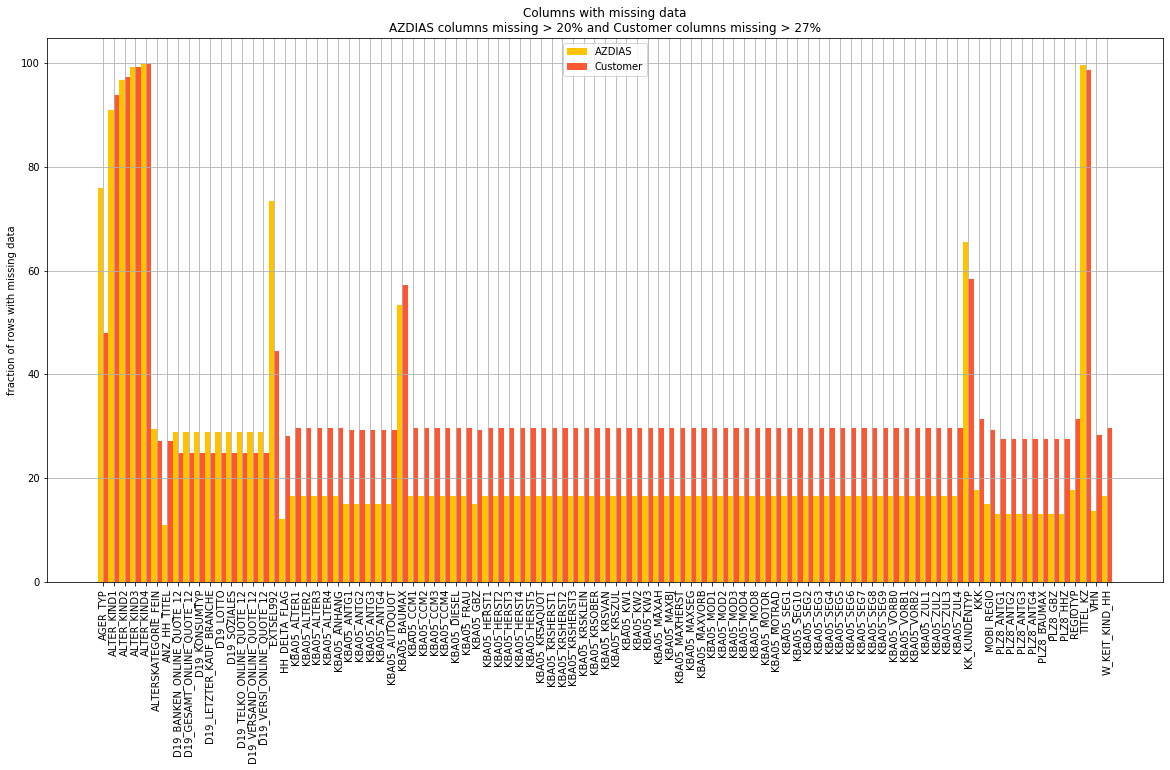

In [87]:
def plot_nulls(df, azdias_prz = 20, customer_prz=30):
    null_counts_plot = temp.query('azdias_val > @azdias_prz or customer_val > @customer_prz')
    plt.figure(figsize=(20,10))
    plt.xticks(np.arange(null_counts_plot.shape[0])+0.25,null_counts_plot['data_columns'].values,rotation='vertical')
    plt.ylabel('fraction of rows with missing data')
    plt.grid()
    plt.bar(np.arange(null_counts_plot.shape[0]),null_counts_plot['azdias_val'], width=0.5, color='#FFC300', label='AZDIAS');
    plt.bar(np.arange(null_counts_plot.shape[0])+0.5, null_counts_plot['customer_val'], width=0.5, color='#FF5733',label='Customer');
    plt.legend()
    plt.title('Columns with missing data\nAZDIAS columns missing > {}% and Customer columns missing > {}%'.format(azdias_prz,customer_prz))
plot_nulls(temp,20,27)

I will drop evrything missing more than 40%.
It look like the missing values are all missing in the same rows, therefore I will investigate into the rows. 

In [88]:
null_counts[null_counts > 40].index

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [89]:
azdias_altered = azdias_altered.drop(null_counts[null_counts > 40].index, 1)
customers = customers.drop(null_counts[null_counts > 40].index, 1)
azdias_altered.shape, customers.shape

((891221, 357), (191652, 360))

## <a class="anchor" id="Rows">1.1.3.2 Rows</a>

There might be some rows missing more than 50% of data which I will drop as well

In [90]:
azdias_altered['NaN_Count'] = 1-azdias_altered.count(axis=1)/len(azdias_altered.columns)
azdias_altered['NaN_Count'].head(10)

0    0.697479
1    0.025210
2    0.000000
3    0.011204
4    0.000000
5    0.000000
6    0.002801
7    0.000000
8    0.025210
9    0.000000
Name: NaN_Count, dtype: float64

In [91]:
customers['NaN_Count'] = 1-customers.count(axis=1)/len(customers.columns)
customers['NaN_Count'].head(10)

0    0.000000
1    0.672222
2    0.000000
3    0.008333
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.008333
9    0.000000
Name: NaN_Count, dtype: float64

In [92]:
azdias_altered_15 = azdias_altered[azdias_altered['NaN_Count'] <= 0.15]
azdias_altered_85 = azdias_altered[azdias_altered['NaN_Count'] > 0.15]

customers_15 = customers[customers['NaN_Count'] <= 0.15]
customers_85 = customers[customers['NaN_Count'] > 0.15]

In [93]:
azdias_altered_15.shape, azdias_altered_85.shape

((737288, 358), (153933, 358))

In [94]:
customers_15.shape, customers_85.shape

((134246, 361), (57406, 361))

Next I will plot the worst columns concerning the missing data in the 85% dataframe

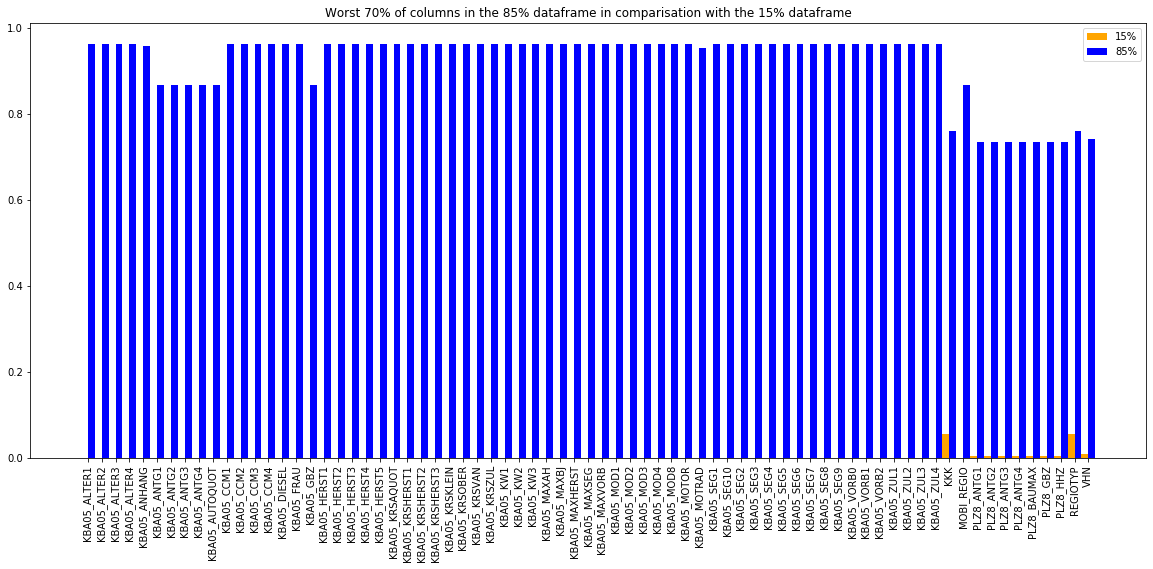

In [95]:
def plot_nan_rows_70(df_15,df_85):
    null_counts_15 = df_15.isnull().sum()/len(df_15)
    null_counts_85 = df_85.isnull().sum()/len(df_85)

    null_counts_15 = null_counts_15[null_counts_85>0.70]
    null_counts_85 = null_counts_85[null_counts_85>0.70]
    
    
    plt.figure(figsize=(20,8))
    plt.xticks(np.arange(len(null_counts_85))+0.25, null_counts_85.index, rotation='vertical')
    plt.bar(np.arange(len(null_counts_15)),null_counts_15, color='orange',width = 0.5, label='15%')         
    plt.bar(np.arange(len(null_counts_85))+0.5,null_counts_85, color='b',width = 0.5, label='85%')
    plt.legend()
    plt.title('Worst 70% of columns in the 85% dataframe in comparisation with the 15% dataframe')
    plt.show();
plot_nan_rows_70(azdias_altered_15, azdias_altered_85);

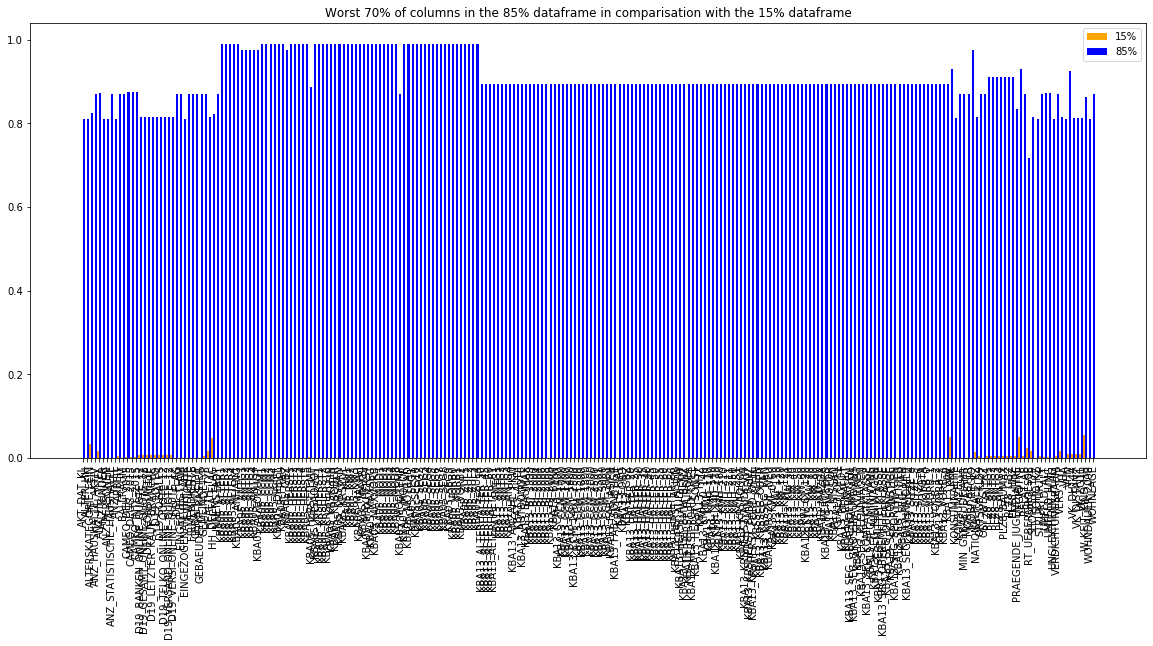

In [96]:
plot_nan_rows_70(customers_15, customers_85);

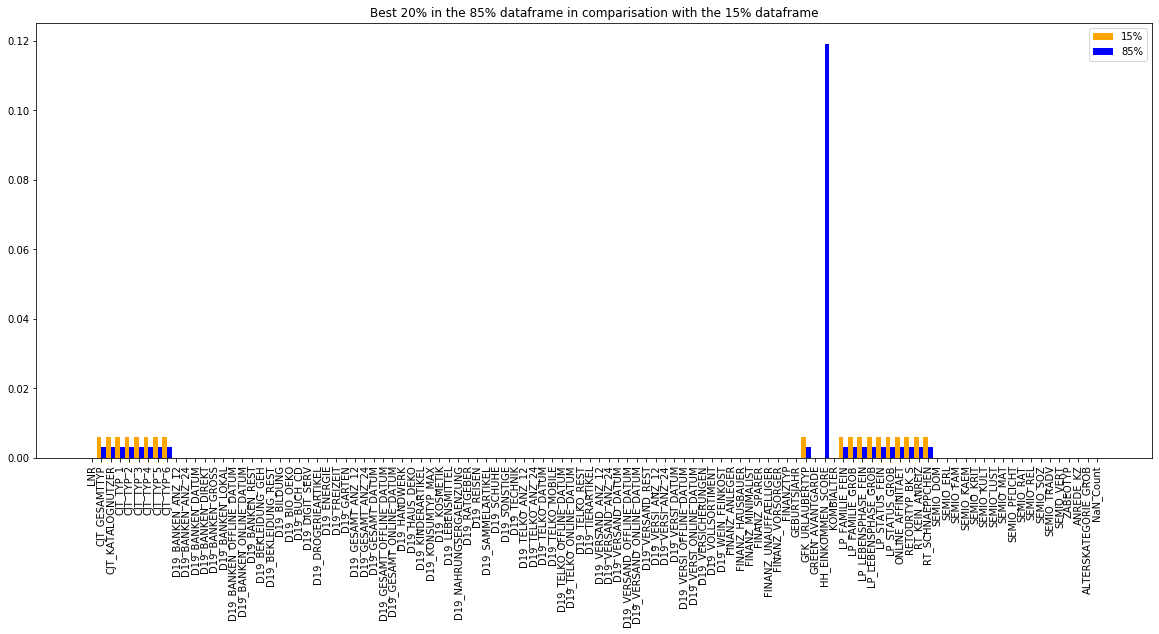

In [97]:
def plot_nan_rows_20(df_15,df_85):
    null_counts_15 = df_15.isnull().sum()/len(df_15)
    null_counts_85 = df_85.isnull().sum()/len(df_85)

    null_counts_15 = null_counts_15[null_counts_85<0.20]
    null_counts_85 = null_counts_85[null_counts_85<0.20]

    plt.figure(figsize=(20,8))
    plt.xticks(np.arange(len(null_counts_85))+0.25, null_counts_85.index, rotation='vertical')
    plt.bar(np.arange(len(null_counts_15)),null_counts_15, color='orange',width = 0.5, label='15%')         
    plt.bar(np.arange(len(null_counts_85))+0.5,null_counts_85, color='b',width = 0.5, label='85%')
    plt.legend()
    plt.title('Best 20% in the 85% dataframe in comparisation with the 15% dataframe')
    plt.show();
plot_nan_rows_20(azdias_altered_15,azdias_altered_85)

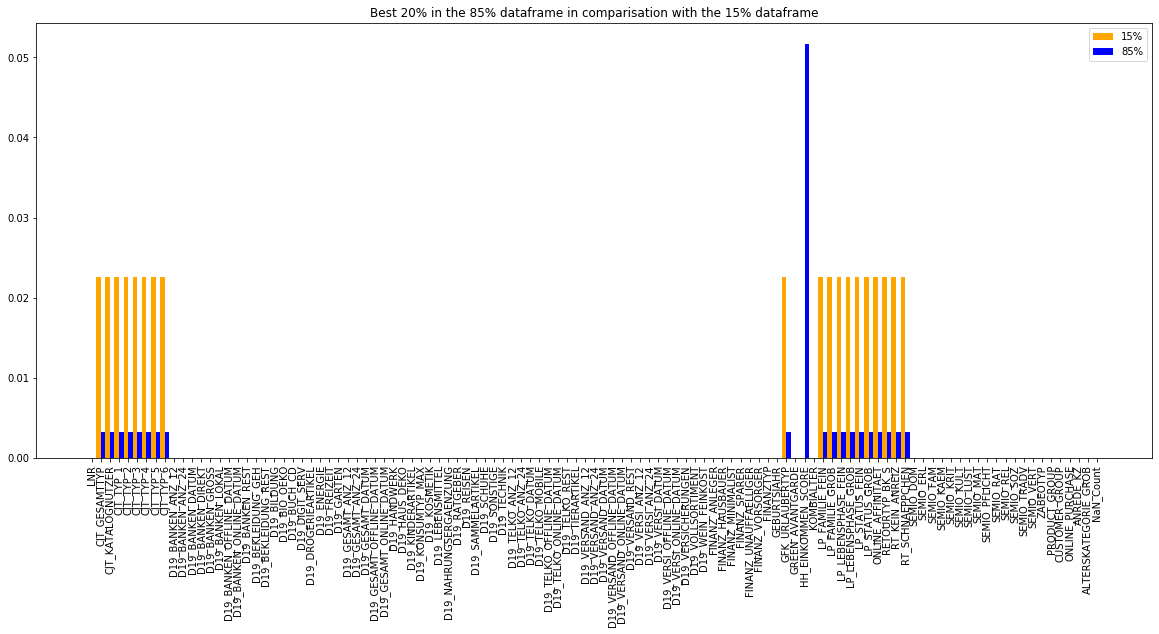

In [98]:
plot_nan_rows_20(customers_15,customers_85)

What kind of data will we be missing

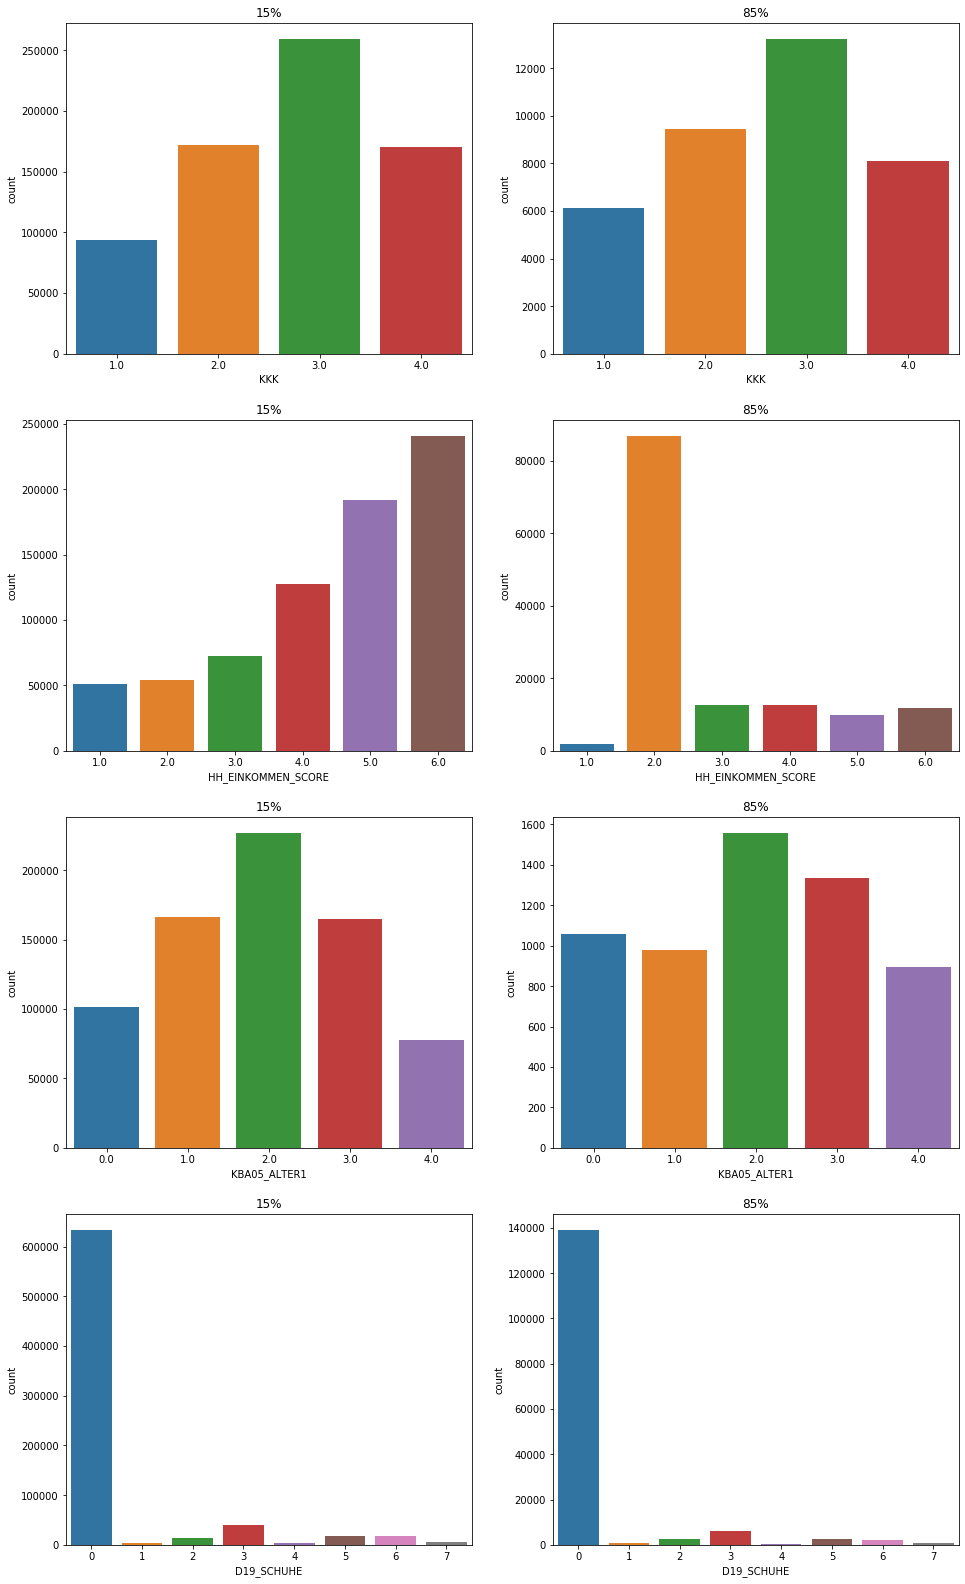

In [99]:
def compare_plot(df_1, df_2, columns, title_1='15%', title_2='85%', figsize_x = 16, figsize_y = 28):
    plt.figure(figsize=(figsize_x,figsize_y))
    counter=1
    for col in columns:
        plt.subplot(len(columns),2,counter)
        plt.title(title_1)
        sns.countplot(x=col,data=df_1)
        counter+=1
        plt.subplot(len(columns),2,counter)
        plt.title(title_2)
        sns.countplot(x=col,data=df_2)
        counter+=1
    plt.show();
compare_plot(azdias_altered_15,azdias_altered_85,['KKK','HH_EINKOMMEN_SCORE','KBA05_ALTER1', 'D19_SCHUHE'])

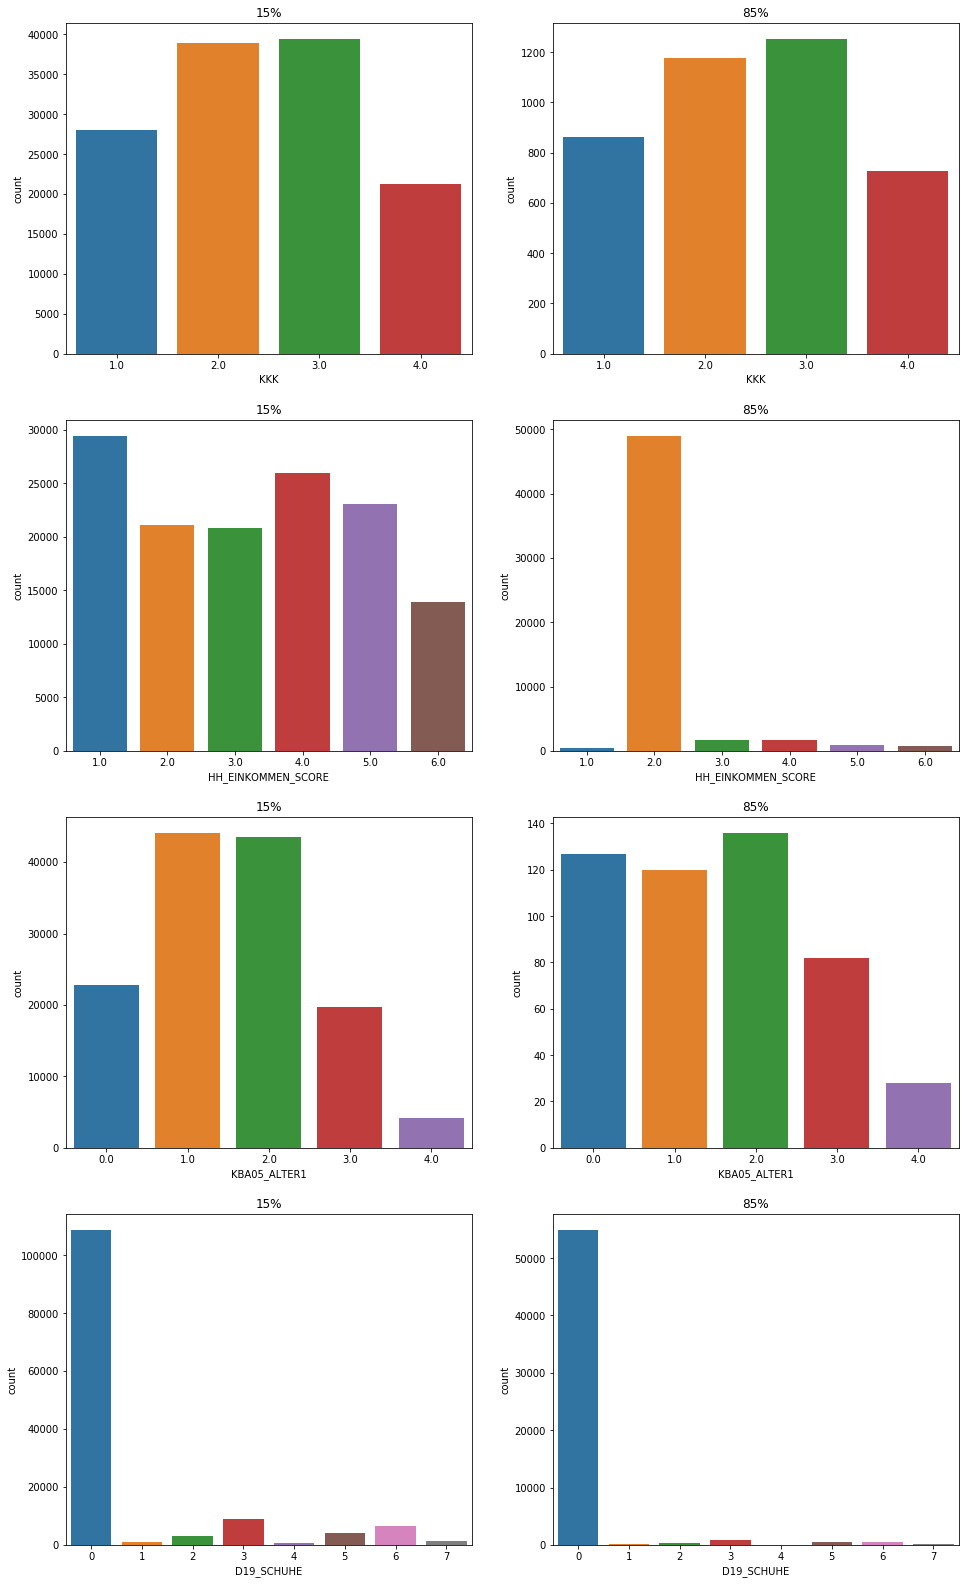

In [100]:
compare_plot(customers_15,customers_85,['KKK','HH_EINKOMMEN_SCORE','KBA05_ALTER1', 'D19_SCHUHE'])

After the comparism of randomly picked rows I will dropp all rows missing at least 85% of their content. The data is very similar between the two datasets so that we would not loose too much "special" data. Filling the missing values would damage the prediction drasticly.

In [101]:
azdias_altered = azdias_altered_15.drop(['NaN_Count'], axis=1)
customers = customers_15.drop(['NaN_Count'], axis=1)

In [102]:
float_columns = ['ANZ_HAUSHALTE_AKTIV',
'ANZ_HH_TITEL',
'ANZ_PERSONEN',
'ANZ_TITEL',
'GEBURTSJAHR',
'KBA13_ANZAHL_PKW',
'MIN_GEBAEUDEJAHR']

In [103]:
azdias_altered[azdias_altered.columns[azdias_altered.dtypes == 'object'].values].columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM',
       'OST_WEST_KZ'],
      dtype='object')

In [104]:
object_columns = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM','OST_WEST_KZ']

In [105]:
int_columns = np.setdiff1d(azdias_altered.columns,float_columns+object_columns)

In [131]:
def fill_columns(df, columns, filling):
    bar = progressbar.ProgressBar(maxval=len(columns)+1, widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter = 0
    for col in columns:
        if filling == 'mean':
            df[col]=df[col].fillna(df[col].mean())
        if filling == 'median':
            df[col]=df[col].fillna(df[col].median())
        counter+=1
        bar.update(counter)
    bar.finish()
    return df

In [107]:
azdias_altered = fill_columns(azdias_altered, float_columns, 'mean')
azdias_altered = fill_columns(azdias_altered, int_columns, 'median')

[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


In [108]:
customers = fill_columns(customers, float_columns, 'mean')

object_columns=list(customers[customers.columns[customers.dtypes == 'object'].values].columns)

int_columns= np.setdiff1d(customers.columns,float_columns+object_columns)
customers = fill_columns(customers, int_columns, 'median')

[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


In [109]:
(azdias_altered.isnull().sum()/len(azdias_altered)).sort_values(ascending=False)[:3]

D19_LETZTER_KAUF_BRANCHE    0.222534
CAMEO_DEU_2015              0.004530
KBA05_ANTG4                 0.000000
dtype: float64

In [110]:
(customers.isnull().sum()/len(customers)).sort_values(ascending=False)[:3]

D19_LETZTER_KAUF_BRANCHE    0.006950
CAMEO_DEU_2015              0.002235
KBA05_CCM1                  0.000000
dtype: float64

In [111]:
azdias_altered.D19_LETZTER_KAUF_BRANCHE.unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_SONSTIGE', 'D19_BANKEN_GROSS', 'D19_VOLLSORTIMENT',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_LEBENSMITTEL',
       'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'D19_SAMMELARTIKEL',
       'D19_TELKO_MOBILE', 'D19_REISEN', 'D19_BEKLEIDUNG_GEH',
       'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG', 'D19_DIGIT_SERV',
       'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_FREIZEIT',
       'D19_WEIN_FEINKOST', 'D19_GARTEN', 'D19_BILDUNG',
       'D19_BANKEN_LOKAL'], dtype=object)

I will fill the D19_LETZTER_KAUF_BRANCHE with D19_Unbekannt

In [112]:
azdias_altered['D19_LETZTER_KAUF_BRANCHE'] = azdias_altered['D19_LETZTER_KAUF_BRANCHE'].fillna('D19_UNBEKANNT')
customers['D19_LETZTER_KAUF_BRANCHE'] = customers['D19_LETZTER_KAUF_BRANCHE'].fillna('D19_UNBEKANNT')

In [113]:
azdias_altered.CAMEO_DEU_2015.unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '7A',
       '5D', '9E', '5C', '9B', '1B', '8B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6E', '6D', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

Based on the fact that the rows I will loose by dropping all remaining nan are only 0.4% or less of the data, I will just drop them.

In [114]:
azdias_altered = azdias_altered.dropna(axis=0)
customers = customers.dropna(axis=0)

In [115]:
azdias_altered.to_csv('azdias_altered.csv', sep='\t', index=False)
customers.to_csv('customers_altered.csv', sep='\t', index=False)

# <a class="anchor" id="Cleaning">1.1.4 Cleaning Function</a>

Initialize all we need for the Function

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

Reload the raw data

In [110]:
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

#save for later comarism
azdias_size = azdias.shape 
#customers_size = customers.shape 


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Te same fill function from above

In [18]:
def fill_columns(df, columns, filling):
    
    bar = progressbar.ProgressBar(maxval=len(columns)+1, widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter = 0
    for col in columns:
        if filling == 'mean':
            df[col]=df[col].fillna(df[col].mean())
        if filling == 'median':
            df[col]=df[col].fillna(df[col].median())
        counter+=1
        bar.update(counter)
    bar.finish()
    return df

The cleaning function simply does the same things than the boxex above in one function 

In [107]:
def cleanup(df, clustering_set = True):
    y=[]
    
    if list(np.intersect1d(list(df.columns),['RESPONSE'])) == ['RESPONSE']:
        y=df[['RESPONSE','LNR']]
        df = df.drop(['RESPONSE'], 1)
    
    if list(np.intersect1d(list(df.columns),['Unnamed: 0'])) == ['Unnamed: 0']:
        df = df.drop('Unnamed: 0',1)
        
    nan_df = pd.read_csv('nan_list_altered.tsv', sep='\t')
    nan_df['nan_values'] = nan_df['nan_values'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))
    
    
    bar = progressbar.ProgressBar(maxval=len(nan_df['column'])+1, widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter=0
    
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['nan_values'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                print('error in {}'.format(col))
        counter+=1
        bar.update(counter)
    bar.finish()
    
    df['KBA13_VORB_1a'] = df['KBA13_VORB_1']
    df = df.drop(['KBA13_VORB_1'], 1)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: int(x) if x==x else x )
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x) if x==x else x )
    
    null_counts_columns = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4','EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
    df = df.drop(null_counts_columns, 1)
    
    #only drop the rows if we clean for clustering
    if clustering_set:
        df['NaN_Count'] = 1-df.count(axis=1)/len(df.columns)
        df = df[df['NaN_Count'] <= 0.15]
        df = df.drop(['NaN_Count'], axis=1)
    
    
    float_columns = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','ANZ_KINDER','ANZ_STATISTISCHE_HAUSHALTE']
    object_columns = list(df.columns[df.dtypes == 'object'].values)
    int_columns = np.setdiff1d(df.columns,float_columns+object_columns)  

    
    df = fill_columns(df, float_columns, 'mean')
    df = fill_columns(df, int_columns, 'median')
    df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].fillna('D19_UNBEKANNT')
    
    

    df = df.dropna(how='any')
    
    
    if len(y) > 0:
        df = df.merge(y, on='LNR', how='left')
    
    print('Done!')
    return df
    

In [111]:
azdias = cleanup(azdias)
#customers = cleanup(customers)

[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


Done!


In [112]:
azdias.shape

(733948, 357)

# <a class="anchor" id="One-Hot">1.2.1 Transforming and One Hot Coding</a>

The cooding function does the following steps:

* dropping unneccesary columns
* convert ther INT columns with values between 1-2 to INT 0-1
* reencode PRAEGENDE_JUGENDJAHRE into decades
* reencode CAMEO_INTL_2015 into HOUSEHOLD and FAMALY_TYPE
* one-hot code all categorical columns

In [113]:
def coding(df):
    bar = progressbar.ProgressBar(maxval=5, widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    azdias = False
    
    df=df.drop(['LNR','EINGEFUEGT_AM','GEBURTSJAHR'],1)# LNR is the Linenumber, EINGEFUEGT_AM is the date of the entry and GEBURTSJAHR is encodet into the PRAEGENDE_JUGENDJAHRE
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 0 if x == 'W' else 1).astype(int)
    df['ANREDE_KZ'] = df['ANREDE_KZ'].apply(lambda x: x-1).astype(int)
    df['VERS_TYP'] = df['VERS_TYP'].apply(lambda x: x-1).astype(int)
    
    # for the customers df
    if list(np.intersect1d(list(df.columns),['CUSTOMER_GROUP'])) == ['CUSTOMER_GROUP']:
        df = df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], 1)
    else:
        azdias = True
        
    
    decade_ranges = ["[{0} - {1})".format(decade, decade + 10) for decade in range(1940, 2000, 10)]
    
    bar.update(1)
    
    trans_df = pd.DataFrame({'az_id':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],'id':[0,0,1,1,2,2,2,3,3,4,4,4,4,5,5],'MAINSTREAM':[1,0,1,0,1,0,0,1,0,1,0,1,0,1,0]})

    temp_df = pd.DataFrame({'PRAEGENDE_JUGENDJAHRE_RANGE':decade_ranges, 'id':range(6)})
    temp_df = pd.merge(trans_df, temp_df, on='id').drop(['id'],axis=1)
    temp_df = pd.merge(df, temp_df, left_on='PRAEGENDE_JUGENDJAHRE', right_on='az_id').drop(['az_id'], axis=1)
    
    df = temp_df.copy()
    temp_df = None
    
    bar.update(2)
    
    trans_df = pd.DataFrame({'az_id':[11,12,13,14,15,21,22,23,24,25,31,32,33,34,35,41,42,43,44,45,51,52,53,54,55],
                         'HOUSEHOLD':[1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5],
                         'FAMALY_TYPE':[1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5]})
    
    df = pd.merge(df, trans_df, left_on='CAMEO_INTL_2015', right_on='az_id').drop('az_id', axis=1)
    
    drop_it = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    df = df.drop(drop_it, axis=1)

    df = pd.get_dummies(df, columns=['HOUSEHOLD','FAMALY_TYPE','PRAEGENDE_JUGENDJAHRE_RANGE'])
    
    bar.update(3)
    
    bin_columns = list(df.columns[(df.nunique()==2).values].values)
    bin_columns = list(set(bin_columns))
    
    float_columns = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE']
    
    object_columns = list(df.columns[df.dtypes == 'object'].values)
    object_columns = list(set(object_columns))
    
    int_columns = np.setdiff1d(df.columns,float_columns+object_columns)
    int_columns = np.setdiff1d(int_columns,bin_columns) 
    int_columns = list(set(int_columns))
    
    bar.update(4)
    
    for col in int_columns:
        df[col] = df[col].astype(int)
    for col in bin_columns:
        df[col] = df[col].astype(int)
        
    df = pd.get_dummies(df, columns=['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'])
    
    if azdias:
        df['D19_TELKO_ONLINE_QUOTE_12_3'] = 0 #only exists in customers
        
    if list(np.intersect1d(list(df.columns),['PRODUCT_GROUP'])) == ['PRODUCT_GROUP']:
        df = pd.get_dummies(df, columns=['PRODUCT_GROUP'])
    
    
    bar.finish()
    
    bar = progressbar.ProgressBar(maxval=len(int_columns), widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    cntr = 0
    df = pd.get_dummies(df, columns=int_columns)

    #order the columns again from a - z
    temp = df.columns.to_list()
    temp.sort()
    df = df[temp]
    
    
    bar.finish()
    return df



In [114]:
azdias = coding(azdias)

[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


In [115]:
azdias.shape

(733948, 2251)

In [9]:
#customers = coding(customers)

# <a class="anchor" id="Scaling">1.3.1 Scaling</a>

Scaling the values is important, not all algorithms can compensate for a large spread between min and max of a column

In [26]:
def do_scaling_fit_transform(df):
    scale_model = StandardScaler().fit(df)
    X = scale_model.transform(df)
    return X, scale_model

def do_scaling(scale_model,df):
    trans_x = scale_model.transform(df)
    return trans_x

In [10]:
X, scale_model = do_scaling_fit_transform(azdias)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# <a class="anchor" id="Segmentation_Report">Part 1: Customer Segmentation Report</a>

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

# <a class="anchor" id="PCA">2.1.1 PCA Dimension Reduction</a>

For a better data handling I use a PCA dinmensional reduction

In [8]:
from sklearn.decomposition import PCA

def do_pca_fit_transform(n_compo, df):
    pca = PCA(n_compo)
    X_pca = pca.fit_transform(df)
    return pca, X_pca

def do_pca(pca, df):
    trans_x_pca = pca.transform(df)
    return trans_x_pca

Normaly one should use at least the half of the column count for PCA but with my 16GB RAM 1000 was the maximum

In [12]:
len(azdias.columns.values)

2251

In [13]:
pca, X_pca = do_pca_fit_transform(1000, X)

In [15]:
sum(pca.explained_variance_ratio_)

0.7376967358825212

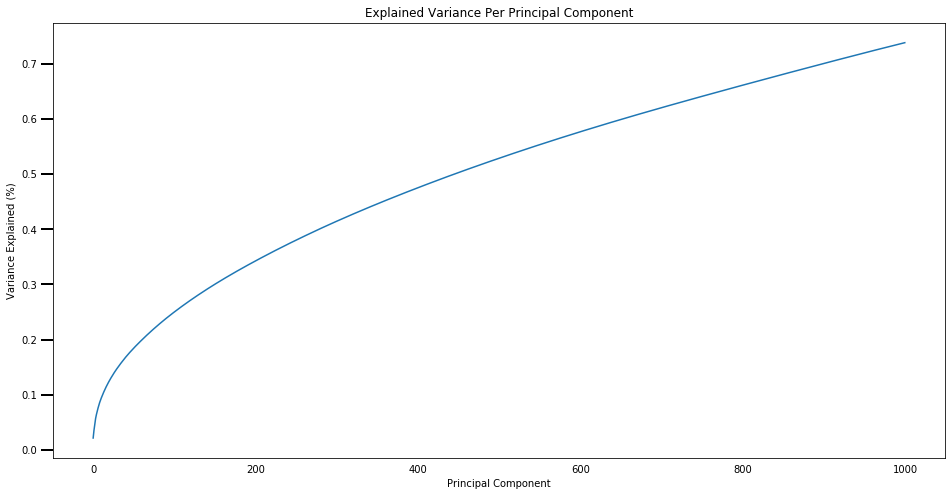

In [16]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    #ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

# <a class="anchor" id="Principal_Components">2.1.2 Interpret Principal Components</a>

I will print the first 3 components and try to interprete them I will look at the first 10 and the last 10 entries of the components sorted by their values.

In [17]:
len(pca.components_[0])


2514

In [14]:
def list_component(df, pca, nth_compo):
    listing = pd.DataFrame({'Features':list(df.keys()),'Weights':pca.components_[nth_compo]}).sort_values('Weights', axis=0, ascending=False).values.tolist()
    #listing.head()+listing.tail()
    return listing[:10]+['^^^HEAD','TAILvvv']+listing[-10:]

list_component(azdias,pca,0)


[['PLZ8_BAUMAX_1', 0.09052004979006999],
 ['KBA13_BAUMAX_1', 0.09011812499404996],
 ['KBA13_ANTG4_0', 0.08033528154816572],
 ['PLZ8_ANTG4_0', 0.07764463872935447],
 ['KBA05_ANTG4_0', 0.06287052881507577],
 ['ANZ_PERSONEN', 0.06225265449777795],
 ['MOBI_REGIO_5', 0.06153125962526889],
 ['FINANZ_MINIMALIST_5', 0.06036210394514629],
 ['KBA13_ANTG1_3', 0.05974089716095453],
 ['KBA05_ANTG3_0', 0.05768945521693126],
 '^^^HEAD',
 'TAILvvv',
 ['D19_GESAMT_ANZ_24_0', -0.0720154891302663],
 ['HOUSEHOLD_5', -0.07342515525913926],
 ['HH_EINKOMMEN_SCORE_6', -0.07586210651281883],
 ['PLZ8_ANTG3_3', -0.07880938454945552],
 ['KBA13_ANTG3_3', -0.07939733950259585],
 ['KBA05_ANTG1_0', -0.08235153555254233],
 ['PLZ8_ANTG1_1', -0.08518560670944954],
 ['KBA13_ANTG1_1', -0.08550854552246007],
 ['LP_STATUS_GROB_1', -0.08646812271396792],
 ['MOBI_RASTER_1', -0.09123974746655705]]

The most important features:


**Positive side:**
* there are mainly 1-2 famaly homes in the zip code area: 'PLZ8_BAUMAX_1'
* there are mainly 1-2 famaly homes in the region: 'KBA13_BAUMAX_1'
* there aren't houses holding 10 Famalies at once in the region


**Negative side:**
* MOBI_RASTER isn't mentioned in the disclaimer but I guess it has something to do with mobility and movement of the customer 1 stands for very high mobility. For beeing negative as a feature it means customers who are not very mobil
* Poore people: LP_STATUS_GROB_1 so beeing not poor is significant
* lower share of 1-2 Famaly houses in the region: KBA13_ANTG1_1 therefor it is significant when there are many 1-2 Famaly homes in the region


In [15]:
list_component(azdias,pca,1)

[['ONLINE_AFFINITAET_5', 0.09027490963738463],
 ['PRAEGENDE_JUGENDJAHRE_RANGE_[1990 - 2000)', 0.08377188790922793],
 ['D19_VERSAND_ONLINE_QUOTE_12_10', 0.08178616031185043],
 ['D19_GESAMT_ONLINE_QUOTE_12_10', 0.08031178186836306],
 ['D19_KONSUMTYP_1', 0.07808978302490951],
 ['CJT_TYP_2_5', 0.06888173947714664],
 ['CJT_TYP_1_5', 0.066708509384438],
 ['CJT_TYP_5_2', 0.06296185690587607],
 ['ZABEOTYP_4', 0.06246416598701839],
 ['KOMBIALTER_2', 0.06231776513632528],
 '^^^HEAD',
 'TAILvvv',
 ['CJT_TYP_4_5', -0.08682816117164584],
 ['D19_GESAMT_ONLINE_DATUM_10', -0.08719232982047026],
 ['D19_VERSAND_ONLINE_DATUM_10', -0.08743922351901291],
 ['D19_VERSAND_ANZ_12_0', -0.08750007011151821],
 ['D19_VERSAND_ANZ_24_0', -0.08781110997359759],
 ['KOMBIALTER_4', -0.08803181705937646],
 ['D19_GESAMT_ANZ_24_0', -0.0883595940075452],
 ['D19_VERSAND_ONLINE_QUOTE_12_0', -0.09060424530189412],
 ['D19_GESAMT_ANZ_12_0', -0.09160701033075494],
 ['D19_GESAMT_ONLINE_QUOTE_12_0', -0.09462997108073529]]

Second most important feature

**Positive side:**

* having the highest online affinity: ONLINE_AFFINITAET_5
* The customers youth was mostly influenced by the years 1990-2000: PRAEGENDE_JUGENDJAHRE_RANGE_\[1990 \- 2000)
* all mailorders where done onmline within the last 12 month: D19_VERSAND_ONLINE_QUOTE_12_10

**Negative Side**

* confirming the third feature: D19_GESAMT_ONLINE_QUOTE_12_0 means no online transactions, take it negative and you get customer who did all transactions online
* having no known transactions in the last 12 month: D19_GESAMT_ANZ_12_0 so having any is significant here
* D19_VERSAND_ONLINE_QUOTE_12_0 is just the opposite of D19_VERSAND_ONLINE_QUOTE_12_10

In [20]:
list_component(azdias,pca,2)

[['OST_WEST_KZ', 0.10372206446587925],
 ['KBA13_SEG_SPORTWAGEN_1', 0.0985373376318459],
 ['FINANZ_UNAUFFAELLIGER_1', 0.09218464015740009],
 ['KOMBIALTER_4', 0.08665394285823229],
 ['KBA13_SEG_OBERKLASSE_1', 0.08213479727495424],
 ['KBA13_SITZE_5_5', 0.0812376522596264],
 ['FINANZ_SPARER_1', 0.08088085675253097],
 ['KBA13_CCM_3001_1', 0.07919453673142929],
 ['KBA13_SEG_KOMPAKTKLASSE_5', 0.07888386766052939],
 ['ALTERSKATEGORIE_GROB_4', 0.07834128449565432],
 '^^^HEAD',
 'TAILvvv',
 ['FINANZ_MINIMALIST_1', -0.05021079754956284],
 ['KOMBIALTER_2', -0.050725673647863616],
 ['LP_LEBENSPHASE_GROB_1', -0.05164822609398271],
 ['RT_KEIN_ANREIZ_5', -0.0559638101330611],
 ['CJT_TYP_2_5', -0.0612229267993766],
 ['PRAEGENDE_JUGENDJAHRE_RANGE_[1990 - 2000)', -0.06138294686962772],
 ['FINANZ_UNAUFFAELLIGER_5', -0.06316347478429217],
 ['CJT_TYP_1_5', -0.06597156109179447],
 ['KBA13_ANZAHL_PKW', -0.06597855853901158],
 ['FINANZTYP_1', -0.06765474282191065]]

Third most important feature

**Positive side:**

* living in the east of germany is significant: OST_WEST_KZ
* share of sportscars within the zip code area is low: KBA13_SEG_SPORTWAGEN_1
* financial typology: unremarkability is very low: FINANZ_UNAUFFAELLIGER_1

**Negative Side**

* low financial intrest: FINANZTYP_1 negative meaning is more than low fin. intrest
* number of cars in the zip code area: KBA13_ANZAHL_PKW negative means lower is more significant
* CJT_TYP_1 isn't mentioned in the disclaimer but it tells you something about the advertisment influence and the shopping behaviour of the customer on the negative side it means the person isn't the Advertising- and Cross-Channel-Enthusiast

# <a class="anchor" id="Clustering">2.2.1 Clustering</a>

I will approach the clustering with the kmeans algorithm, to find the right amount of clusters for this dataset I will plot the score for each cluster amount between 1 and 20.

In [16]:
from sklearn.cluster import KMeans

In [ ]:
centers = []
score = []
for i in range(20):
    kmean = KMeans(i+1)
    model = kmean.fit(X_pca)
    centers.append(i+1)
    score.append(abs(model.score(X_pca)))

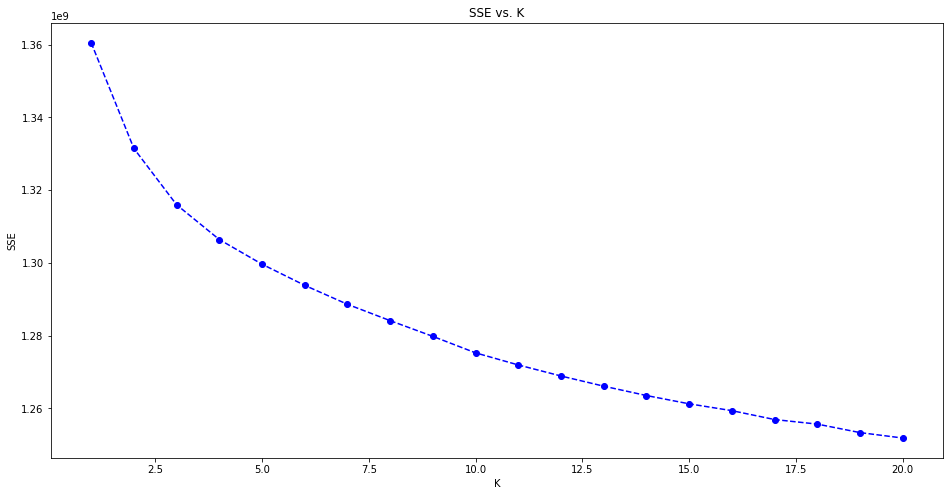

In [27]:
plt.figure(figsize=(16, 8))
plt.plot(centers, score, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

The ideal case for a decission over the amount of clusters with the help of a score plot is when the graph forms an elbow, meaning that to a certain point there is a significant drop in score (less is better) and from that point there is no further change.

In my plot is no significant elbow point but if you look at the amount of 20 clusters you can see no significant change in steepness will come afterwards and if you think about the underlying case of a mail order company there isn't a precise way to pinpoint one specific group out of more than 20 groups with ads or campaigns therefor it suffices to cluster in this range.

In [17]:
kmean = KMeans(20)
model = kmean.fit(X_pca)
g_preds = model.predict(X_pca)


# <a class="anchor" id="Customers_Clustering">2.2.2 Apply All Steps to the Customers Data</a>


In [116]:
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
customers_size = customers.shape 
customers = cleanup(customers)

[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


Done!


In [117]:
customers.shape

(133946, 360)

In [90]:
print('Data loss in %')
(100-(azdias.shape[0] / azdias_size[0])*100),(100-(customers.shape[0]/customers_size[0])*100)

Data loss in %


(17.646913616263532, 30.10978231377706)

30% loss in the customer data is much, I hope the clustering works non the less

In [118]:
customers = coding(customers)

[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


In [119]:
customers.shape

(133946, 2237)

Now I must fill in all the missing columns existing only in the azdias dataset for the scaling

In [188]:
def get_missing_collumns(customers_df, azdias_df):
    for col in list(set(azdias_df.columns.to_list()).difference(set(customers_df.columns.to_list()))):
        customers_df[col] = 0
    temp = customers_df.columns.to_list()
    temp.sort()
    customers_df = customers_df[temp]
    return customers_df

customers = get_missing_collumns(customers,azdias)

In [56]:
# Scaling
customers = do_scaling(scale_model, customers)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [57]:
# Reduction
X_pca_c = do_pca(pca, customers)

In [58]:
# Clustering
c_preds = model.predict(X_pca_c)

# <a class="anchor" id="Compare_Cluster">2.2.3 Global vs Customers, comparing the Clusters</a>

First I will shape a DataFrame made out of both clusterings for a comparism plot.
After the comparism I will have a look into the type of customer ordering at the mail order company and than in the potential customer not yet ordering at the company.

In [59]:
customer_cluster = pd.DataFrame({'cluster':c_preds})
customer_cluster['count']=1
customer_counts = customer_cluster.groupby(['cluster']).size().reset_index(name='counts')
customer_counts['percent'] = customer_counts['counts']/customer_cluster.shape[0]*100

temp=pd.DataFrame({'cluster':list(range(20)), 'counts':[0]*20, 'percent':[0]*20})
customer_counts = pd.merge(customer_counts,temp, on='cluster', how='right').fillna(0)

In [60]:
global_cluster = pd.DataFrame({'cluster':g_preds})
global_cluster['count']=1
global_counts = global_cluster.groupby(['cluster']).size().reset_index(name='counts')
global_counts['percent'] = global_counts['counts']/global_cluster.shape[0]*100


temp=pd.DataFrame({'cluster':list(range(20)), 'counts':[0]*20, 'percent':[0]*20})
global_counts = pd.merge(global_counts,temp, on='cluster', how='right').fillna(0)

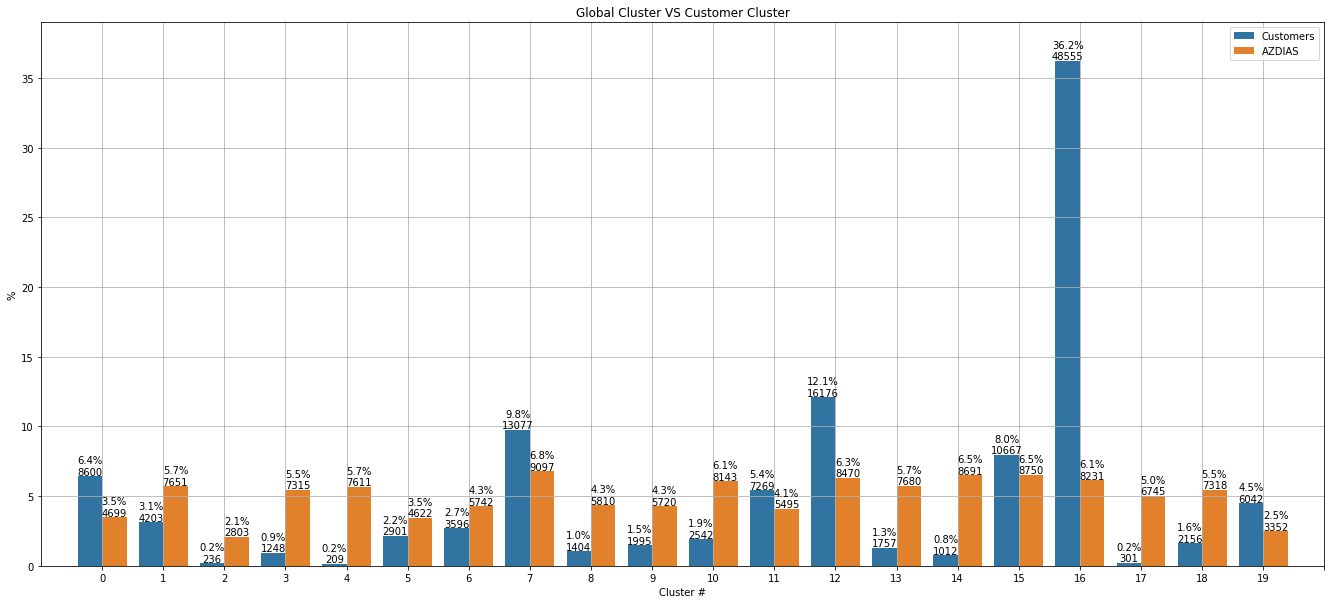

In [62]:
temp = customer_counts.drop(['counts_y','percent_y'],1)
temp['type'] = 'Customers'
global_counts_temp = global_counts.drop(['counts_y','percent_y'],1)
global_counts_temp['type'] = 'AZDIAS'
temp = temp.append(global_counts_temp)

plt.figure(figsize=(23, 10))
ax1 = sns.barplot(x='cluster', y='percent_x', hue='type', data=temp)

plt.grid()
plt.ylim((0.00,39))
plt.xlim((-1,19))
plt.xticks(range(21))
plt.title('Global Cluster VS Customer Cluster')
plt.ylabel('%')
plt.xlabel('Cluster #')
plt.legend()

temp = (temp[temp['type']=='AZDIAS']['counts_x'].sum(),temp[temp['type']=='Customers']['counts_x'].sum())
counter = 1

for p in ax1.patches:
    print
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 0.1,
            '{:1.1f}%\n{:1.0f}'.format(height,height/100.0*temp[2%counter -1]),
            ha="center")
    counter+=1


plt.show()

In [73]:
def list_reconstruct_component(DF, model, nth_compo, pca):
    listing = pd.DataFrame({'Features':list(DF.keys()),'Weights':pca.inverse_transform(model.cluster_centers_)[nth_compo]}).sort_values('Weights', axis=0, ascending=False).values.tolist()
    
    return listing

def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
                                        pca.inverse_transform(kmeans.cluster_centers_[cluster]))),
                               orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values',
                                                                                                 ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

In [87]:
def plot_cluster(df, model, cluster_list, title):
    size=len(cluster_list)
    plt.figure(figsize=(16, size*5))
    for i in range(size):
        plt.subplot(size,1,i+1)
        plot_scaled_comparison(df, model, cluster_list[i])
        plt.title(title + ' cluster ' + str(cluster_list[i]))
    plt.show()

Ordered by importance:

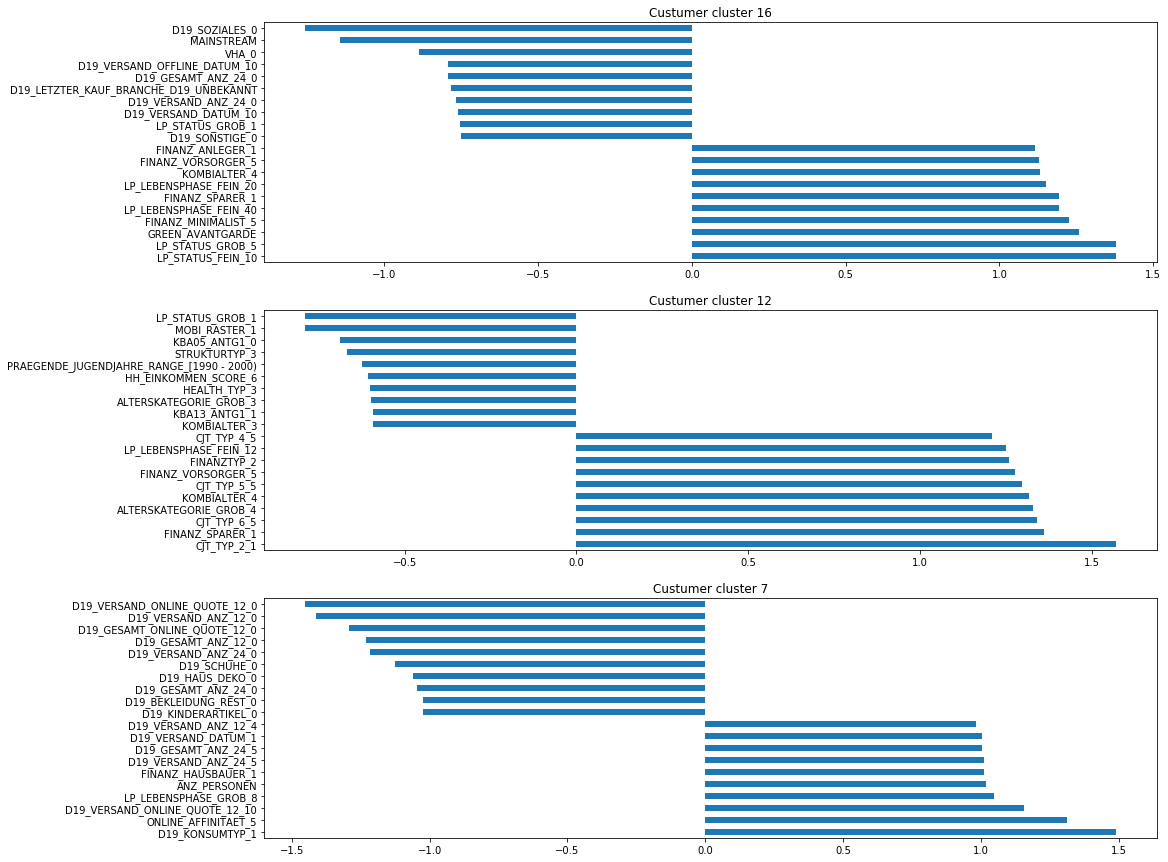

In [91]:
plot_cluster(azdias, model, [16,12,7], 'Custumer')

Each cluster describes one type of customer.

**Cluster 16**
_The average online buyer_

Customers who:

* didn't buy anything in the category "social"
* grew up influenced by the mainstream culture
* VHA isn't described in the disclaimer but 0 normaly means no
* didn't order offline (via mail)

Customers who didn't:

* fall into the category top earners
* fall into the category average earners
* belong to the green avantgarde
* have a very low financial intrest

**Cluster 12**
_The working class_

Customers who:

* fall into the category low income earners
* have a high mobility
* have no 1-2 famaly homes close by

Customers who didn't:

(much information missing ion the disclaimer)

* save much money
* pass his 60th birthday
* ignore financial preparation completely

**Cluster 7**
_The one time mail order buyer_

Customers who:

* orders per mail
* ordered nothing in the last 12 month
* orders in general only per mail


Customers who didn't:

* consumate very universal
* fall in the category hiigh online affinity
* order online

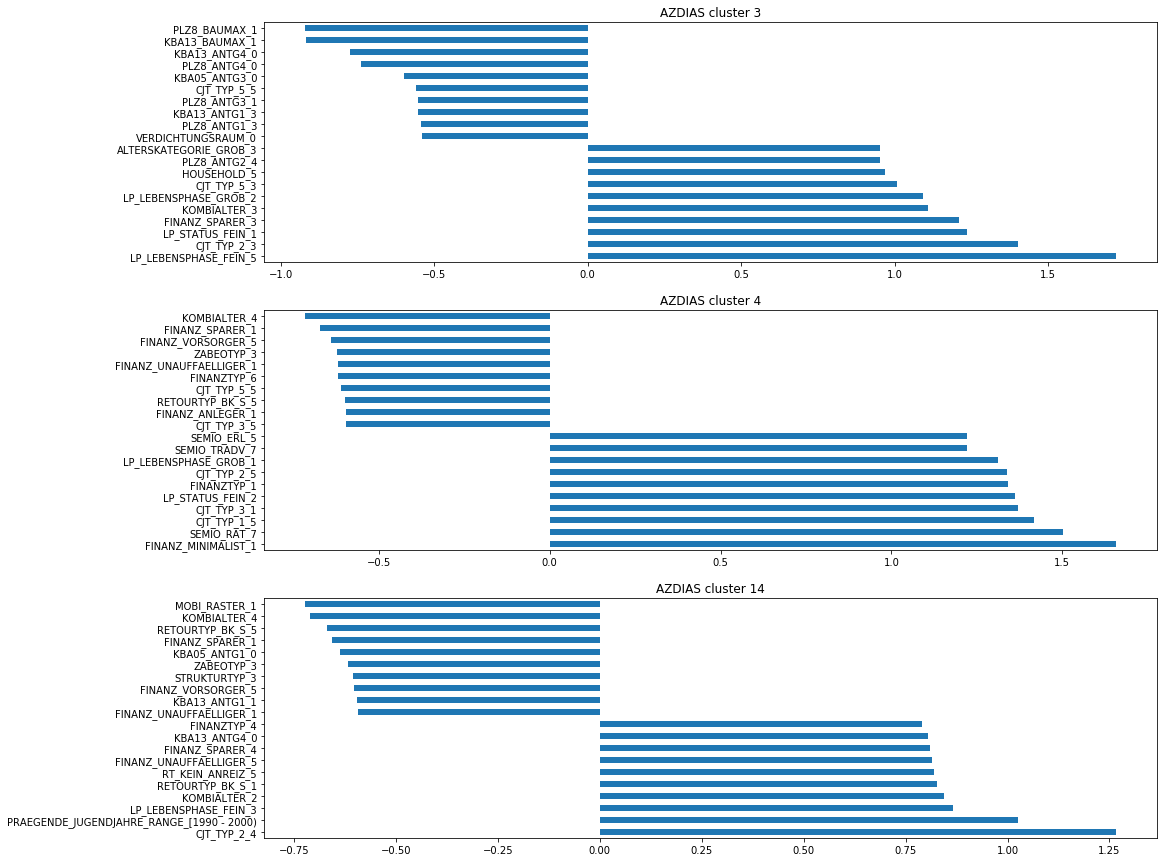

In [92]:
plot_cluster(azdias, model, [3,4,14], 'AZDIAS')

Each cluster describes one type of customer.

**Cluster 3**
_The Rich upper classs single_

Customers who:

* live in a 1-2 famaly homes zip code area
* live in a 1-2 famaly homes micro cell
* live in a micro cell without 10 or more famaly homes 
* live in an zip code area without 10 or more famaly homes

Customers who don't:

* fall into the low income category
* belong to the typical low income earner
* belong to the average money saver
* count as couple

**Cluster 4**
_The average middle_

Customers who:

* save very much money
* doesn't provide for the future, financialy, like investing etc.
* has a normal energy consumption

Customers who don't:

(much information missing in the disclaimer)

* ignore the finances completely
* fall in the category very low affinity to rationality
* fall in the category orientationseeking low-income earners


**Cluster 14**
_The one that lives for the day_

Customers who:

* have a very high mobility
* are determined Minimal-Returner
* save much money


Customers who don't:

* count as pepople influenced by the years 1990 - 2000 in their youth
* count as single average earners of younger age 
* count as influenceable Crazy-Shopper

# <a class="anchor" id="Part2">Part 2: Supervised Learning Model</a>

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

# <a class="anchor" id="Investigating">3.1.1 Investigating the data</a>

Bevore beginnig with the search for the optimal model it is important to have a look at the new column 'RESPONSE'

In [8]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier, GradientBoostingClassifier


from IPython.display import clear_output

from imblearn.over_sampling import RandomOverSampler

In [9]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [81]:
print('The train set contains only {:1.2f}% customers with positive response'.format(mailout_train[mailout_train['RESPONSE'] == 1].shape[0] /mailout_train.shape[0] * 100))

The train set contains only 1.24% customers with positive response


# <a class="anchor" id="Finding_Model">3.1.2 Finding the model</a>

Keeping in mind that the dataset is only filled with 1.2% of positive response, to find the right model for this job I will use a 5 fold cross validation. The cross validation will be done on the whole training set because we have a real testset and result by using the testset from the next step and sending it to the competition.

In [234]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


mailout_train = cleanup(mailout_train, clustering_set=False)


y = mailout_train['RESPONSE']
y = pd.DataFrame(y)
y.index = mailout_train.index
y['RESPONSE'] = y['RESPONSE'].astype(int)
y=np.array(y)

mailout_train = mailout_train.drop(['RESPONSE'],1)

mailout_train = coding(mailout_train)


numerical = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE']

mailout_train[numerical], scale_model = do_scaling_fit_transform(mailout_train[numerical])
X = np.array(mailout_train)


X.shape, y.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


Done!


[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


((35063, 2232), (35063, 1))

The find_model function increases the dataset for each step by 10% starting from 10% until it reaches 100%. For each step a 5 fold cross validation is done and the results are saved into arrays for the plot at the end of the process. The process is done for each model given to the function.

In [99]:
def find_model(X, y, learners):
    
    #plt.figure(figsize=(10,5 * len(learners)))
    plt.figure(figsize=(18,5))
    
    #configure cross validation
    cross_validation = KFold(n_splits=5, random_state=42, shuffle=False)
    sample_sizes = []
    
    #configure steps 10% - 100%
    for i in range(10,110,10):
        sample_sizes.append(int((X.shape[0]/100) * i))

    counter = 1
    
    #for each model
    for l in learners:
        print(l.__class__.__name__)
        
        #arrays for the plot
        cv_score = []
        train_score = []
        
        # configure the plot
        plt.subplot(1, len(learners), counter)
        plt.title(l.__class__.__name__)
        plt.grid()
        counter+=1
        
        #for each step
        for s in sample_sizes:
            print(s)
            
            #arrays for the step results
            sample_cv_score = []
            sample_train_score = []
            
            #5 fold cv
            for train_index, test_index in cross_validation.split(X[:s]):
                X_train, X_test, y_train, y_test = X[train_index],X[test_index],y[train_index], y[test_index]
                y_train = y_train.reshape(len(y_train))
                y_test = y_test.reshape(len(y_test))
                
                #fit the model
                l = l.fit(X_train, y_train)
                
                #predict with the trained model and pull the roc score
                sample_train_score.append(roc_auc_score(y_train, l.predict_proba(X_train)[:,1]))
                sample_cv_score.append(roc_auc_score(y_test, l.predict_proba(X_test)[:,1]))
                
                #print(y_test.sum())
                #print(l.predict_proba(X_test).sum())
                #print(y_train.sum())
                #print(l.predict_proba(X_train).sum())
            
            #pull the middled score over all folds 
            cv_score.append(np.array(sample_cv_score).mean())
            train_score.append(np.array(sample_train_score).mean())
            
            #print(cv_score)
            #print(train_score)
            
        #to see the progress and only the plot at the end 
        clear_output()
        
        plt.xticks(range(10,110,10))
        plt.xlabel('Sample size %')
        plt.ylabel('ROC Score')
        
        sns.lineplot(range(10,110,10), cv_score, label = 'Cross validation score',markers=["o"])
        sns.lineplot(range(10,110,10), train_score, label = 'Train score',markers=["o"])
        
        
    plt.show();
    
    

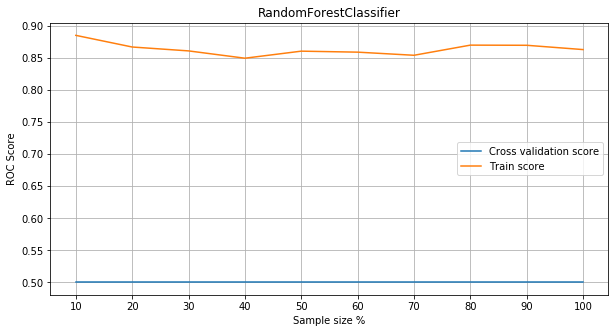

In [149]:
clf_A = RandomForestClassifier(random_state=42, n_estimators = 10)
clf_B = AdaBoostClassifier(random_state=42)
clf_C = GradientBoostingClassifier(random_state=42)



find_model(X, y, [clf_A])

# <a class="anchor" id="try">3.2.1 Re-Do and Second Try</a>

The first results showed that the algoritm just ignored all positive rsponses and just predicted always 0 which is in more than 98% correct but doesn't help. For better result I decided to redo the cleaning and coding at this point.

Tasks for the redo:
Re-Cleaning
* Dropping all columns missing more tan 30% of data
* Dropping all rows missing any data if they have a negative response
* Dropping LP_FAMILIE_GROB, LP_LEBENSPHASE_GROB, LP_STATUS_GROB which are coded in the …_FEIN columns
* Log Skewing the numerical data

Re-Code/Transform
* GEBAEUDETYP -> binary GEBEUDETYP_WOHN_OFFICE
* using Min Max Scaling

In [141]:
#more columns had to be dropped therefore a variable threshold function
def drop_columns(df, threshold = 40):
    null_counts = df.isnull().sum()/len(df)
    null_counts =null_counts*100.0
    column_drop_index = null_counts[null_counts > threshold].index
    df = df.drop(column_drop_index, 1)
    
    return df, column_drop_index

In [143]:
def reclean(df, column_drop_index = []):
    y=[]
    
    if list(np.intersect1d(list(df.columns),['RESPONSE'])) == ['RESPONSE']:
        y=df[['RESPONSE','LNR']]
        df = df.drop(['RESPONSE'], 1)
    
    #sorting for the column indexing
    temp = df.columns.to_list()
    temp.sort()
    df = df[temp]
        
        
    nan_df = pd.read_csv('nan_list_altered.tsv', sep='\t')
    nan_df['nan_values'] = nan_df['nan_values'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))
    
    bar = progressbar.ProgressBar(maxval=len(nan_df['column'])+1, widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter=0
    
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['nan_values'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                print('error in {}'.format(col))
        counter+=1
        bar.update(counter)
    bar.finish()
    
    df['KBA13_VORB_1a'] = df['KBA13_VORB_1']
    df = df.drop(['KBA13_VORB_1'], 1)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: int(x) if x==x else x )
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x) if x==x else x )
    
    if len(column_drop_index) > 0:
        df = df.drop(column_drop_index, 1)
    else:
        df, column_drop_index = drop_columns(df, 30)
        
    df = df.drop(['LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB','LP_STATUS_GROB'], 1)
    
    float_columns = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','ANZ_KINDER','ANZ_STATISTISCHE_HAUSHALTE']
    object_columns = list(df.columns[df.dtypes == 'object'].values)
    int_columns = np.setdiff1d(df.columns,float_columns+object_columns)  
    
    df[float_columns] = df[float_columns].apply(lambda x: np.log(x + 1))
    
    if len(y) > 0:
        df = df.merge(y, on='LNR', how='left')     
    
        df_temp=df.query('RESPONSE == 1')
        temp_index = df.query('RESPONSE == 1').index
        
        df = df.drop(index=temp_index,axis =0)
        df = df.dropna(how='any') #thinning out the 0 response rows
        df = df.append(df_temp)
        df = df.sort_index()

    
    
    
    df = fill_columns(df, float_columns, 'mean')
    df = fill_columns(df, int_columns, 'median')
    
    df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].fillna('D19_UNBEKANNT')
    
      

    
    print('Done!')
    
    return df, column_drop_index

In [238]:
def recoding(df):
    bar = progressbar.ProgressBar(maxval=5, widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    azdias = False
    
    df=df.drop(['LNR','EINGEFUEGT_AM','GEBURTSJAHR'],1)# LNR is the Linenumber, EINGEFUEGT_AM is the date of the entry and GEBURTSJAHR is encodet into the PRAEGENDE_JUGENDJAHRE
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 0 if x == 'W' else 1 if x == 'O' else x)#.astype(int)
    df['ANREDE_KZ'] = df['ANREDE_KZ'].apply(lambda x: x-1).astype(int)
    df['VERS_TYP'] = df['VERS_TYP'].apply(lambda x: x-1).astype(int)
    
    df = pd.get_dummies(df, columns = ['OST_WEST_KZ'], dummy_na = True)
    
    # for the customers df
    if list(np.intersect1d(list(df.columns),['CUSTOMER_GROUP'])) == ['CUSTOMER_GROUP']:
        df = df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], 1)
    else:
        azdias = True
        #df['CUSTOMER_GROUP'] = df['CUSTOMER_GROUP'].apply(lambda x: 0 if x == 'MULTI_BUYER' else 1).astype(int)
    
    decade_ranges = ["[{0} - {1})".format(decade, decade + 10) for decade in range(1940, 2000, 10)]
    
    bar.update(1)
    
    trans_df = pd.DataFrame({'az_id':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],'id':[0,0,1,1,2,2,2,3,3,4,4,4,4,5,5],'MAINSTREAM':[1,0,1,0,1,0,0,1,0,1,0,1,0,1,0]})

    temp_df = pd.DataFrame({'PRAEGENDE_JUGENDJAHRE_RANGE':decade_ranges, 'id':range(6)})
    temp_df = pd.merge(trans_df, temp_df, on='id').drop(['id'],axis=1)
    temp_df = pd.merge(df, temp_df, left_on='PRAEGENDE_JUGENDJAHRE', right_on='az_id').drop(['az_id'], axis=1)
    
    df = temp_df.copy()
    temp_df = None
    
    bar.update(2)
    
    trans_df = pd.DataFrame({'az_id':[11,12,13,14,15,21,22,23,24,25,31,32,33,34,35,41,42,43,44,45,51,52,53,54,55],
                         'HOUSEHOLD':[1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5],
                         'FAMALY_TYPE':[1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5]})
    
    df = pd.merge(df, trans_df, left_on='CAMEO_INTL_2015', right_on='az_id').drop('az_id', axis=1)
    
    drop_it = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    df = df.drop(drop_it, axis=1)
    
    trans_df = pd.DataFrame({'az_id':[1,2,3,4,5,6,7,8],'GEBEUDETYP_WOHN_OFFICE':[1,1,2,2,3,2,3,2]})
    df = pd.merge(df, trans_df, left_on='GEBAEUDETYP', right_on='az_id').drop('az_id', axis=1)
    df = df.drop(['GEBAEUDETYP'], axis=1)

    df = pd.get_dummies(df, columns=['HOUSEHOLD','FAMALY_TYPE','PRAEGENDE_JUGENDJAHRE_RANGE','GEBEUDETYP_WOHN_OFFICE'])
    
    bar.update(3)
    
    bin_columns = list(df.columns[(df.nunique()==2).values].values)
    bin_columns = list(set(bin_columns))
    
    float_columns = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE']
    
    object_columns = list(df.columns[df.dtypes == 'object'].values)#['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM','OST_WEST_KZ']
    object_columns = list(set(object_columns))
    
    int_columns = np.setdiff1d(df.columns,float_columns+object_columns)
    int_columns = np.setdiff1d(int_columns,bin_columns) 
    int_columns = list(set(int_columns))
    
    bar.update(4)
    
    #for col in int_columns:
     #   df[col] = df[col].astype(int)
    #for col in bin_columns:
    #    df[col] = df[col].astype(int)
        
    df = pd.get_dummies(df, columns=['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'], dummy_na = True)
    
    if azdias:
        df['D19_TELKO_ONLINE_QUOTE_12_3'] = 0 #only exists in customers
        
    if list(np.intersect1d(list(df.columns),['PRODUCT_GROUP'])) == ['PRODUCT_GROUP']:
        df = pd.get_dummies(df, columns=['PRODUCT_GROUP'])
    
    
    bar.finish()
    
    bar = progressbar.ProgressBar(maxval=len(int_columns)+1, widgets=[progressbar.Bar('►', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    cntr = 0
    df = pd.get_dummies(df, columns=int_columns)

    
    temp = df.columns.to_list()
    temp.sort()
    df = df[temp]
    
    bar.update(len(int_columns))
    
    
    
    #print(df.columns[df.isna().any()].tolist())
    
    numerical = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE']
    df[numerical] = scale(df[numerical])
    
    bar.finish()
    return df

In [104]:
def scale(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df)
    return df


In [206]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

mailout_train, column_drop_index = reclean(mailout_train)

mailout_train = recoding(mailout_train)

numerical = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE']

mailout_train[numerical] = scale(mailout_train[numerical])

y = mailout_train['RESPONSE']
percentage = y.sum()/len(y)
y = pd.DataFrame(y)
y.index = mailout_train.index
y = np.array(y)
y = y.reshape(len(y))

mailout_train = mailout_train.drop(['RESPONSE'],1)

X = np.array(mailout_train)

X.shape, y.shape, percentage

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


Done!


[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


[]


((27596, 2206), (27596,), 0.01927815625452964)

In [88]:
ros = RandomOverSampler(random_state=0, ratio=0.05, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(X, y)
a = np.array(range(len(X_resampled)))
np.random.shuffle(a)

X_resampled = X_resampled[a]
y_resampled = y_resampled[a]

# <a class="anchor" id="Learning_Curves">3.2.2 Learning Curves</a>

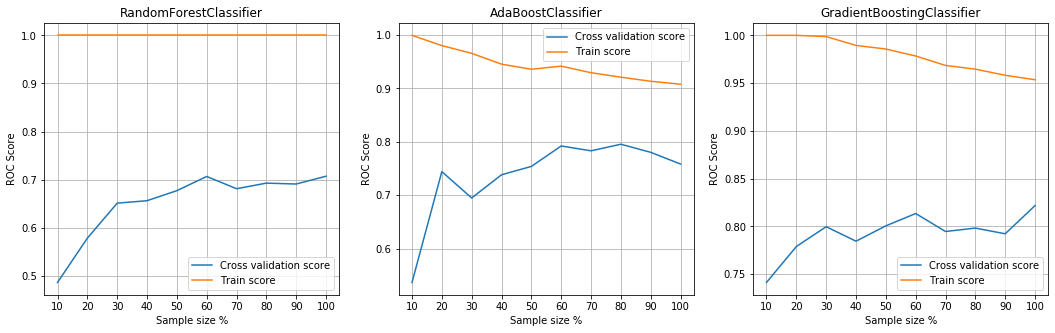

In [106]:
clf_A = RandomForestClassifier(random_state=0, n_estimators = 100)
clf_B = AdaBoostClassifier(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)

find_model(X, y, [clf_A,clf_B,clf_C])

# <a class="anchor" id="Grid">3.3.1 Grid Search</a>

In order to find the perfect parameters for the combination of the data set and the model a grid search cross validation is performed.

In [122]:
clf_C = GradientBoostingClassifier(random_state=0)

In [121]:
# print all possible parameters
clf_C.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

We train on the complete data set for best results

In [131]:
#define the possible parameters
params = {
          "learning_rate"     : [0.1,0.2],
          "max_depth"         : [3,4],
          "n_estimators"      : [100,1000],
          "min_samples_split" : [2,4]}

# start the search
grid = GridSearchCV(clf_C, params, scoring='roc_auc', cv=5)
grid_fit = grid.fit(X_s, y_s)

In [132]:
best = grid_fit.best_estimator_
best.get_params



<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

Parameters which worked best on the data set:
* learning_rate = 0.1
* max_depth = 4
* n_estimators = 100
* min_samples_split = 4

In [133]:
best = best.fit(X, y)

# <a class="anchor" id="Part3">Part 3: Kaggle Competition</a>

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

## <a class="anchor" id="prepare_test">4.1.1 Prepare the Test Data</a>

In [299]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [300]:
def drop_diff_colls(df_model, df_predict):
    cols_to_drop = np.setdiff1d(df_predict.columns.to_list(), df_model.columns.to_list())
    df_predict = df_predict.drop(cols_to_drop, 1)
    return df_predict

In [301]:
def prepare_train(raw_train_df):
    raw_train_df, column_drop_index = reclean(raw_train_df)
    raw_train_df = recoding(raw_train_df)

    return raw_train_df, column_drop_index

def prepare_test(test_df, done_train_df, column_drop_index):
    
    #test_df = test_df.drop(['RESPONSE'],1)
    test_df, column_drop_index = reclean(test_df, column_drop_index)
    
    y_df = pd.DataFrame(test_df['LNR'])
    y_df['RESPONSE'] = np.nan
    y_df.index = test_df.index

    test_df = get_missing_collumns(test_df, done_train_df)
    test_df = test_df.drop(['RESPONSE'],1)
    test_df = drop_diff_colls(done_train_df, test_df)
    
    X = np.array(test_df)
    
    return X, y_df

mailout_train, column_drop_index = prepare_train(mailout_train)
X, y_df = prepare_test(mailout_test, mailout_train, column_drop_index)

[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


Done!


[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%
[►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►►] 100%


Done!


## <a class="anchor" id="predict_kaggle">4.1.2 Prediction and Results</a>

In [302]:
y_df['RESPONSE'] = best.predict_proba(X)[:,1]

In [303]:
y_df.to_csv('kaggle_competition.csv', sep=',', index = False)

Score = 0.47020 Yay!

# <a class="anchor" id="apendixl">Appendix l: Conclusion and Future Work</a>

While following the predefined structure this project went through different steps and reveled much information which was hidden in the data.


* In the pre-processing phase which is for many Data Science projects the most time consuming part, the project had to overcome the lack of description to many features and the sheer overload of different features. Non the less it was possible to define, unify and mend the missing data problem. Some compressed information was re-coded and some unnecessary data was dropped.


* With the pre-processed data the project went through  the unsupervised learning / clustering phase. In order to shrink down the complexity of the data 1000 components werde selected via a PCA analysis taking care of 70% of explained variance. The Clustering then reveled that the main customer of the mail order company can be described as the average mainstream online buyer who never orders offline.


* Then the problems started appear and the cleaning / coding step had to be redesigned and redone. With the new design the model choice could be made resulting in the GradientBoosting model.


* The model was then fine tuned by doing a grid search cross validation with different parameters. To prepare the last step the tuned model was trained on the whole data set to be able to predict the response of the Kaggle Challenge.

A project is never really finished, there is always something to improve. With the redone pre processing it would be very interesting how a redone data set would perform on the unsupervised section.
With all the sophisticated models out there, and this pre processed data set applying any other model could result in even better results for the challenge. Here the possibilities seem endless, reading papers coming fresh out of the science Community.
Concerning the small margin of 1.2% positive response, I experimented with re sampling them which unfortunately ended in over fitting, but maybe I wasn't careful enough. I think there is still some potential in this approach.

# <a class="anchor" id="apendixll">Appendix ll: Sources and Thanks</a>

My Github with the Code [here](https://github.com/Nokaido/Capstone_Project).


The data source was provided by Bertelsmann Arvato Analytics and is not open to public access. 


A big THANKS to [Elena Ivanova](https://towardsdatascience.com/@elenaivanova_65377?source=follow_footer--------------------------follow_footer-) and her [article](https://towardsdatascience.com/customer-segmentation-report-for-arvato-financial-solutions-b08a01ac7bc0) for giving me some guidance on this matter.


Thanks to the Udacity team, the Data Science course rocks!